In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
#import swifter
from scipy import stats
%matplotlib inline

In [2]:
connection = {
'host': 'https://',
'password': '####',
'user': '####',
'database': '####'
}

q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as group,
    uniqExact(user_id)
FROM {db}.feed_actions
WHERE toDate(time) >= '2022-12-02' and toDate(time) <= '2022-12-08'
group by group
"""
pandahouse.read_clickhouse(q, connection=connection)


,group,uniqExact(user_id)
0,0,10091
1,1,9976
2,2,9966
3,3,10140
4,4,9976


In [11]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


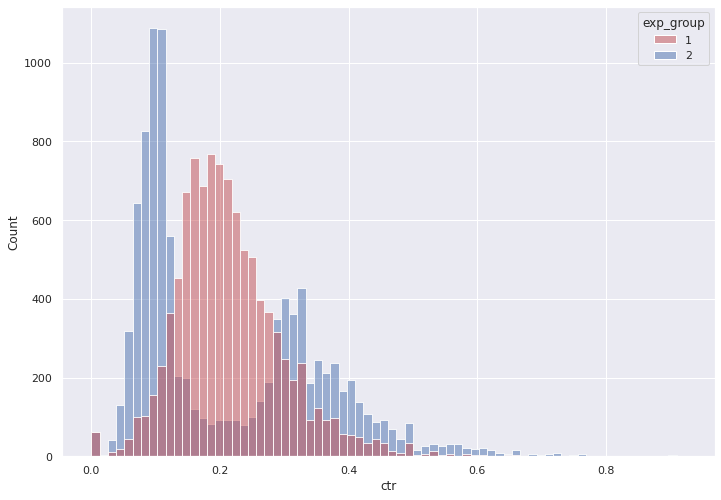

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df,
x='ctr',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

CTR distributions in groups 1 and 2 are significantly different. In the test group 2 the distribution is abnormal, 2 humps can be seen.

In [13]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
df[df.exp_group == 1].ctr,
equal_var=False)

Ttest_indResult(statistic=-0.7094392041270486, pvalue=0.4780623130874935)

A p-value result significantly greater than 0.05 indicates that we cannot reject the H0. However, the graph shows differences in the distributions of these groups.

Let's do a Poisson bootstrap test and look at the distribution in groups 1 and 2.

In [16]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=3000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

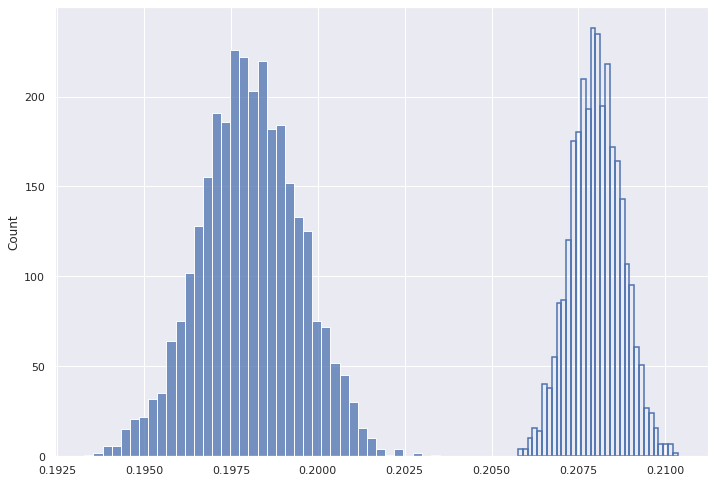

In [20]:
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()


ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)


sns.histplot(ctr1, fill=False)
sns.histplot(ctr2)


The groups do not overlap, which means that p-value will be zero during the tests, which allows us to reject the H0 about the equality of the distributions of groups 1 and 2. It means that the update should not be rolled out so as not to worsen the CTR metrics. However, let`s try to run more tests.



<AxesSubplot:ylabel='Count'>

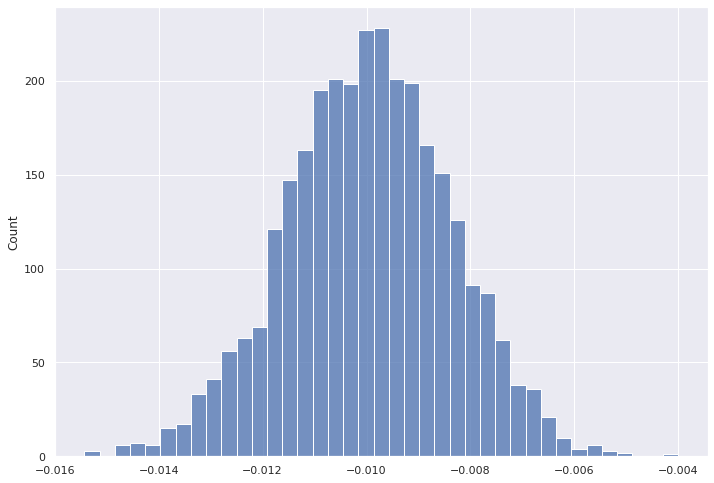

In [23]:
sns.histplot(ctr2 - ctr1)

Group 1(ctr1, control) shows better results than group 2(ctr2, target).
It means that the new algorithm does not work with a positive effect.

Let's try to make another test - bucket transform with Mann-Whitney test and t-test.

In [24]:
q = """
SELECT exp_group, bucket,
sum(likes)/sum(views) as bucket_ctr,
quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group,
xxHash64(user_id)%50 as bucket,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
and exp_group in (1,2)
GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
df[df.exp_group == 2].bucket_ctr,
alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

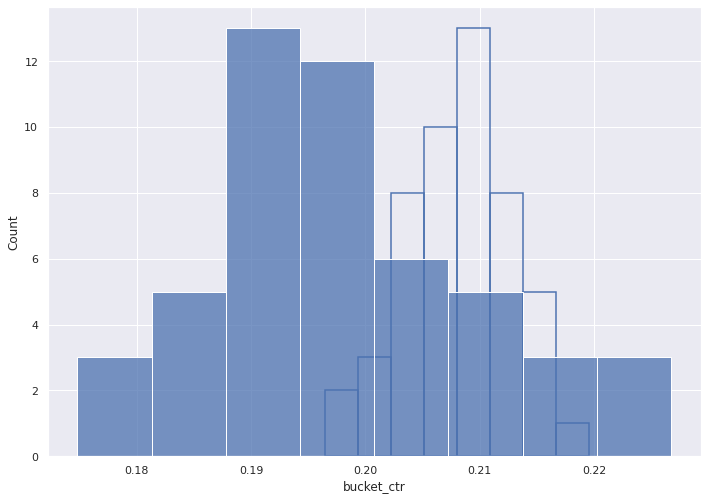

In [26]:
sns.histplot(df[df.exp_group == 1].bucket_ctr, fill=False )
sns.histplot(df[df.exp_group == 2].bucket_ctr)

In [27]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
df[df.exp_group == 2].bucket_ctr,
equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

Mann-Whitney tests and the t-test show that the inequality of distributions was confirmed.
Also, a decrease of CTR value in the test group.

As a result of all tests, we can conclude that it is not worth implementing a new algorithm for all users, despite the fact that the control group has an average CTR higher than the test group and, obviously, in a certain proportion of users in the test group increased the CTR (CTR moved to the right relative to the mean distribution of the control group), but in the majority of users in the test group the CTR decreased (moved to the left relative to the mean distribution of the control group).
